### Exercise 13-1
In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months. Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival function for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [22]:
# first load the data and packaged needed. 

import thinkstats2
import thinkplot

import numpy as np
import pandas as pd

from os.path import basename, exists

import nsfg

import survival

def MakeSurvivalFromCdf(cdf, label=""):
    """Makes a survival function based on a CDF.

    cdf: Cdf

    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)
        
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

    
def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)
    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])
    
def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames
    """
    for i in range(5):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])   
    
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)
        
    
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [23]:
# build and cleanup the dataframe
#download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz")
#download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
#download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")

#resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

#resps = [resp5, resp6, resp7]

CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]        


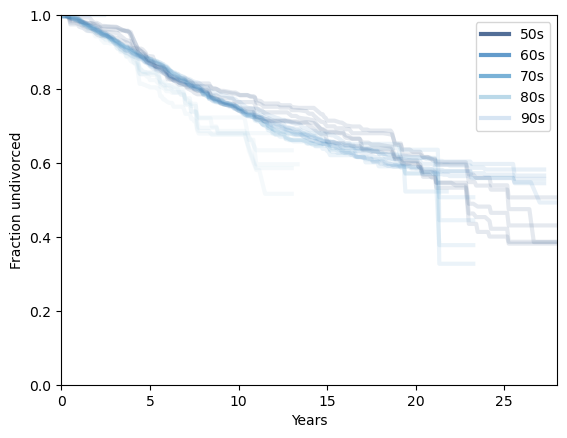

In [24]:
import warnings
warnings.filterwarnings('ignore')

ResampleDivorceCurveByDecade([married6, married7])

#### Conclusion:
   To make the chart more read-able, my code run resample 5 times.
   1. the 50s and 60s, which are raised in a more conserved culture,  are quite consistent. with the years of marriage extended, the divorice rate increased. when couples married more than 20 year. it become relatiely steady. almost 60% of couples stay married regardless of years of marriage. 
   2. for newer generations like those birth dates fall into 80s and 90s, the divorce rate is more violent. there are small jumpe in first 5 years of marriage, then between 5-20 years of marriage, the divorce rate increased (undivorce rate decreased) in a slower rate than the older generations. then after 23 years of marraige, there are general more couples than those born in 50-60s still stay married (less divorce rate increase)
   3. the resampling brings some noises to all decade groups. for 50/60 and 70 generations, the noise impact shows more after 30 years of marriage. maybe due to now those people are in 1980-90 era so they are also influenced by the idea of "freedom" in marriages.
   4. for newer generations, they are born into a era of "freedom", so the resample shows noise even after 5 years of marriages. looks like between year of 12-17 years the divorce rate is related stable, maybe due to the need to rasing children make divorce a harder decision to make.  